# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [39]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [40]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [41]:
len(df)

3877

In [42]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [43]:
df['categoria'].value_counts()

esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

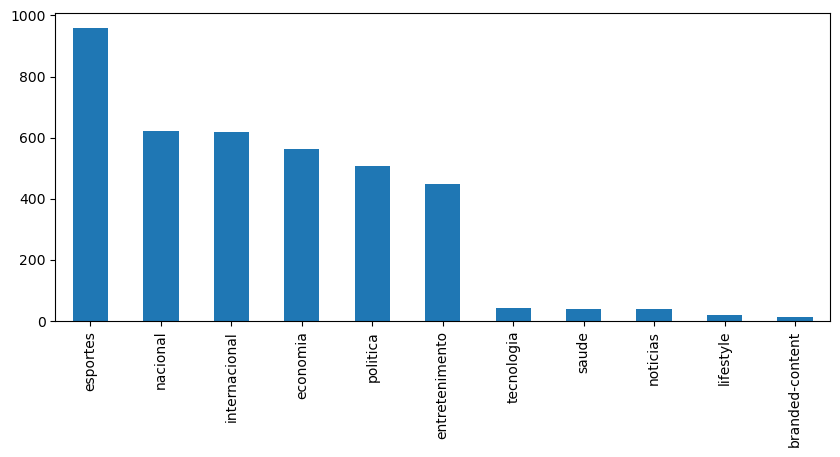

In [44]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [45]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [46]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [47]:
df['categoria'].value_counts()

esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

In [48]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [49]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

In [50]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Saiba quantos milhões o Fluminense ganhará de ...,Campeão da Libertadores neste sábado (4) ao ve...,https://www.cnnbrasil.com.br/esportes/saiba-qu...,Clube carioca conquistou o seu primeiro título...,esportes,2023-11-04 23:28:36
1,Inglaterra x Malta: horário e onde assistir ao...,Inglaterra e Malta se enfrentam nesta sexta-fe...,https://www.cnnbrasil.com.br/esportes/inglater...,"Equipes se enfrentam nesta sexta-feira (17), à...",esportes,2023-11-17 13:24:50
2,"Decisivo, atacante do Corinthians achou que ia...","Aos 36 minutos do segundo tempo, Giovane entro...",https://www.cnnbrasil.com.br/esportes/decisivo...,Giovane ficou fora dos gramados por mais de do...,esportes,2023-11-29 13:20:29
3,América-MG reelege Alencar da Silvera Jr. como...,"O América-MG teve, na noite desta terça-feira ...",https://www.cnnbrasil.com.br/esportes/america-...,Conselho de Administração do Clube terá duas m...,esportes,2023-11-29 00:33:15
4,Tite evita assunto no Flamengo: ‘Não quero ser...,O Flamengo cedeu o empate contra o Fluminense ...,https://www.cnnbrasil.com.br/esportes/tite-evi...,Questionado sobre aspecto físico do elenco na ...,esportes,2023-11-12 16:02:23


In [51]:
# pega coluna
text = df_balanceado['texto']
len(text)

2700

In [52]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

In [53]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [54]:
from unidecode import unidecode

for i in range(len(text)):
    text[i] = unidecode(text[i])

In [55]:
for i in range(len(text)):
    text[i] = re.sub(r'[^a-zA-Z\s]', "" ,text[i])

In [56]:
print(text[0])

campeao da libertadores neste sabado  ao vencer o boca juniors por  a  no maracana o fluminense ira encher os cofres com uma premiacao milionaria por conta da historica campanha o clube carioca recebera um total de  milhoes de dolares cerca de r  milhoes segundo a cotacao atual somente a vitoria deste sabado garantiu  milhoes de dolares r r  milhoes para os novos campeoes da america  milhoes pela taca e mais  milhoes pela classificacao a fase de grupos do torneio no ano que vem  leia mais  ao longo da campanha o fluminense ja havia arrecadado mais  milhoes de dolares r  milhoes em premiacoes da conmebol este conteudo foi criado originalmente em itatiaia versao original


### NLTK

In [57]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [58]:
print(token_text[0])

['campeao', 'da', 'libertadores', 'neste', 'sabado', 'ao', 'vencer', 'o', 'boca', 'juniors', 'por', 'a', 'no', 'maracana', 'o', 'fluminense', 'ira', 'encher', 'os', 'cofres', 'com', 'uma', 'premiacao', 'milionaria', 'por', 'conta', 'da', 'historica', 'campanha', 'o', 'clube', 'carioca', 'recebera', 'um', 'total', 'de', 'milhoes', 'de', 'dolares', 'cerca', 'de', 'r', 'milhoes', 'segundo', 'a', 'cotacao', 'atual', 'somente', 'a', 'vitoria', 'deste', 'sabado', 'garantiu', 'milhoes', 'de', 'dolares', 'r', 'r', 'milhoes', 'para', 'os', 'novos', 'campeoes', 'da', 'america', 'milhoes', 'pela', 'taca', 'e', 'mais', 'milhoes', 'pela', 'classificacao', 'a', 'fase', 'de', 'grupos', 'do', 'torneio', 'no', 'ano', 'que', 'vem', 'leia', 'mais', 'ao', 'longo', 'da', 'campanha', 'o', 'fluminense', 'ja', 'havia', 'arrecadado', 'mais', 'milhoes', 'de', 'dolares', 'r', 'milhoes', 'em', 'premiacoes', 'da', 'conmebol', 'este', 'conteudo', 'foi', 'criado', 'originalmente', 'em', 'itatiaia', 'versao', 'origin

In [59]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [61]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [62]:
print(token_text[0])

['campeao', 'libertadores', 'neste', 'sabado', 'vencer', 'boca', 'juniors', 'maracana', 'fluminense', 'ira', 'encher', 'cofres', 'premiacao', 'milionaria', 'conta', 'historica', 'campanha', 'clube', 'carioca', 'recebera', 'total', 'milhoes', 'dolares', 'cerca', 'r', 'milhoes', 'segundo', 'cotacao', 'atual', 'somente', 'vitoria', 'deste', 'sabado', 'garantiu', 'milhoes', 'dolares', 'r', 'r', 'milhoes', 'novos', 'campeoes', 'america', 'milhoes', 'taca', 'milhoes', 'classificacao', 'fase', 'grupos', 'torneio', 'ano', 'vem', 'leia', 'longo', 'campanha', 'fluminense', 'ja', 'havia', 'arrecadado', 'milhoes', 'dolares', 'r', 'milhoes', 'premiacoes', 'conmebol', 'conteudo', 'criado', 'originalmente', 'itatiaia', 'versao', 'original']


In [63]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Saiba quantos milhões o Fluminense ganhará de ...,"[campeao, libertadores, neste, sabado, vencer,...",https://www.cnnbrasil.com.br/esportes/saiba-qu...,Clube carioca conquistou o seu primeiro título...,esportes,2023-11-04 23:28:36
1,Inglaterra x Malta: horário e onde assistir ao...,"[inglaterra, malta, enfrentam, nesta, sextafei...",https://www.cnnbrasil.com.br/esportes/inglater...,"Equipes se enfrentam nesta sexta-feira (17), à...",esportes,2023-11-17 13:24:50


## Análises

In [64]:
from collections import Counter  # Contagem de frequência de palavras usando NLTK 
frequencia_palavras = Counter(token_text[1]) 
print(frequencia_palavras.most_common())

[('inglaterra', 3), ('malta', 2), ('grupo', 2), ('c', 2), ('eliminatorias', 2), ('enfrentam', 1), ('nesta', 1), ('sextafeira', 1), ('h', 1), ('brasilia', 1), ('estadio', 1), ('wembley', 1), ('fase', 1), ('grupos', 1), ('euro', 1), ('jogo', 1), ('nao', 1), ('tera', 1), ('transmissao', 1), ('tv', 1), ('aberta', 1), ('torcedor', 1), ('podera', 1), ('acompanhar', 1), ('confronto', 1), ('sportv', 1), ('canal', 1), ('assinatura', 1), ('globo', 1), ('leia', 1), ('duelo', 1), ('sera', 1), ('lider', 1), ('lanterna', 1), ('enquanto', 1), ('ja', 1), ('classificada', 1), ('tenta', 1), ('primeira', 1), ('vitoria', 1), ('conteudo', 1), ('criado', 1), ('originalmente', 1), ('itatiaia', 1), ('versao', 1), ('original', 1)]


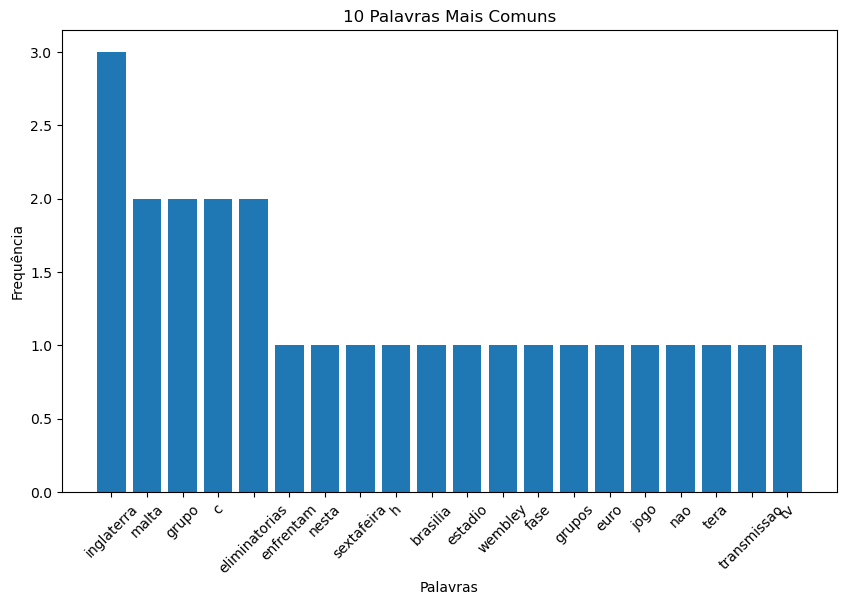

In [65]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = frequencia_palavras.most_common(20)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

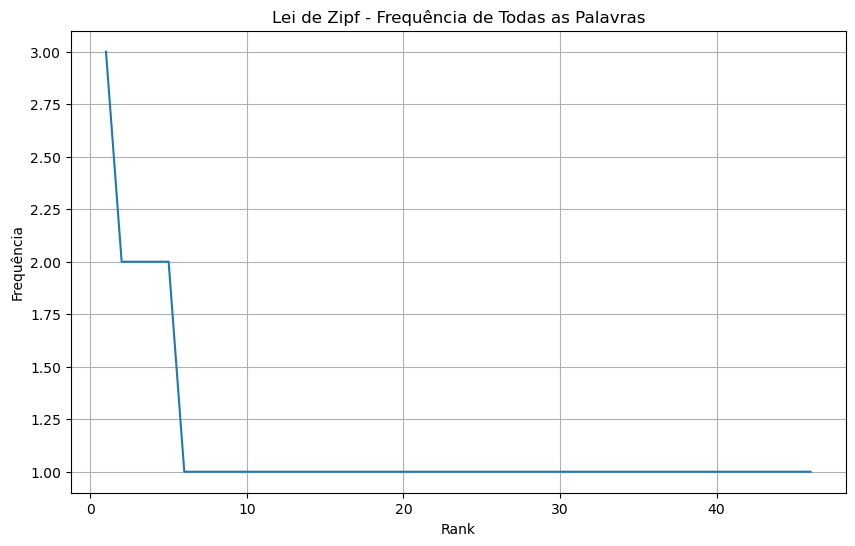

In [66]:
palavras_ordenadas = sorted(frequencia_palavras.items(), key=lambda x: x[1], reverse=True)
palavras, contagens = zip(*palavras_ordenadas)

# Plotar o gráfico da Lei de Zipf
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(palavras) + 1), contagens)
plt.xlabel('Rank')
plt.ylabel('Frequência')
plt.title('Lei de Zipf - Frequência de Todas as Palavras')
plt.grid(True)
plt.show()

## Prediction
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

In [67]:
for i in range(len(token_text)):
    token_text[i] = " ".join(token_text[i])
print(token_text[0])

campeao libertadores neste sabado vencer boca juniors maracana fluminense ira encher cofres premiacao milionaria conta historica campanha clube carioca recebera total milhoes dolares cerca r milhoes segundo cotacao atual somente vitoria deste sabado garantiu milhoes dolares r r milhoes novos campeoes america milhoes taca milhoes classificacao fase grupos torneio ano vem leia longo campanha fluminense ja havia arrecadado milhoes dolares r milhoes premiacoes conmebol conteudo criado originalmente itatiaia versao original


In [68]:
df_balanceado['texto'] = token_text
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Saiba quantos milhões o Fluminense ganhará de ...,campeao libertadores neste sabado vencer boca ...,https://www.cnnbrasil.com.br/esportes/saiba-qu...,Clube carioca conquistou o seu primeiro título...,esportes,2023-11-04 23:28:36
1,Inglaterra x Malta: horário e onde assistir ao...,inglaterra malta enfrentam nesta sextafeira h ...,https://www.cnnbrasil.com.br/esportes/inglater...,"Equipes se enfrentam nesta sexta-feira (17), à...",esportes,2023-11-17 13:24:50
2,"Decisivo, atacante do Corinthians achou que ia...",minutos segundo tempo giovane entrou campo lug...,https://www.cnnbrasil.com.br/esportes/decisivo...,Giovane ficou fora dos gramados por mais de do...,esportes,2023-11-29 13:20:29
3,América-MG reelege Alencar da Silvera Jr. como...,americamg noite desta tercafeira eleicoes defi...,https://www.cnnbrasil.com.br/esportes/america-...,Conselho de Administração do Clube terá duas m...,esportes,2023-11-29 00:33:15
4,Tite evita assunto no Flamengo: ‘Não quero ser...,flamengo cedeu empate contra fluminense neste ...,https://www.cnnbrasil.com.br/esportes/tite-evi...,Questionado sobre aspecto físico do elenco na ...,esportes,2023-11-12 16:02:23


In [69]:
col = ['categoria', 'texto']
df_balanceado = df_balanceado[col]

In [70]:
df_balanceado.head()

,categoria,texto
0,esportes,campeao libertadores neste sabado vencer boca ...
1,esportes,inglaterra malta enfrentam nesta sextafeira h ...
2,esportes,minutos segundo tempo giovane entrou campo lug...
3,esportes,americamg noite desta tercafeira eleicoes defi...
4,esportes,flamengo cedeu empate contra fluminense neste ...


In [71]:
df_balanceado['category_id'] = df_balanceado['categoria'].factorize()[0]
from io import StringIO
category_id_df = df_balanceado[['categoria', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'categoria']].values)
df_balanceado.head()

,categoria,texto,category_id
0,esportes,campeao libertadores neste sabado vencer boca ...,0
1,esportes,inglaterra malta enfrentam nesta sextafeira h ...,0
2,esportes,minutos segundo tempo giovane entrou campo lug...,0
3,esportes,americamg noite desta tercafeira eleicoes defi...,0
4,esportes,flamengo cedeu empate contra fluminense neste ...,0


In [80]:
## Bag of Words model - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=sw)
features = tfidf.fit_transform(df_balanceado['texto']).toarray()
labels = df_balanceado.category_id
features.shape

(2700, 19380)

In [83]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2

for categoria, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(categoria))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'economia':
  . Most correlated unigrams:
. reforma
. bilhoes
  . Most correlated bigrams:
. banco central
. reforma tributaria
# 'entretenimento':
  . Most correlated unigrams:
. fas
. cantora
  . Most correlated bigrams:
. shared by
. post shared
# 'esportes':
  . Most correlated unigrams:
. rodada
. campeonato
  . Most correlated bigrams:
. itatiaia versao
. originalmente itatiaia
# 'internacional':
  . Most correlated unigrams:
. gaza
. israel
  . Most correlated bigrams:
. defesa israel
. faixa gaza
# 'nacional':
  . Most correlated unigrams:
. civil
. policia
  . Most correlated bigrams:
. defesa civil
. policia civil
# 'politica':
  . Most correlated unigrams:
. supremo
. stf
  . Most correlated bigrams:
. supremo tribunal
. tribunal federal


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_balanceado['texto'], df_balanceado['categoria'], random_state = 2)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/hworld/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/hworld/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/hworld/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/hworld/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/hworld/.local/lib/python3.10/s

In [96]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.905926
LogisticRegression        0.888148
MultinomialNB             0.881852
RandomForestClassifier    0.784444
Name: accuracy, dtype: float64

In [98]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_balanceado.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/home/hworld/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [97]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,target_names=df_balanceado['categoria'].unique()))

                precision    recall  f1-score   support

      esportes       0.99      0.97      0.98       140
      nacional       0.87      0.89      0.88       147
 internacional       0.90      0.91      0.91       159
      economia       0.89      0.92      0.90       137
      politica       0.86      0.76      0.80       141
entretenimento       0.93      0.98      0.95       167

      accuracy                           0.91       891
     macro avg       0.91      0.90      0.90       891
  weighted avg       0.91      0.91      0.91       891

